In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install flair

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.1/373.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.5/788.5 kB 45.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 119.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 68.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 92.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 31.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 M

In [3]:
from flair.data import Corpus
from flair.datasets import ColumnCorpus
from flair.embeddings import TokenEmbeddings, WordEmbeddings, StackedEmbeddings, FlairEmbeddings, FastTextEmbeddings
from typing import List

In [4]:
# French corpus of 19 texts from ECHR (official translations) with projected annotations (reviewed)

columns = {0:'text', 1:'ner'}

corpus_folder = '/content/drive/MyDrive/.../'
corpus : Corpus = ColumnCorpus(corpus_folder, columns,
                                    train_file='FR-projected-rev-official.tsv', column_delimiter=' ',
                                    dev_file=None,
                                    test_file=None
)

# obtain and print corpus statistics
stats = corpus.obtain_statistics()
print(stats)

2023-09-18 16:22:24,793 Reading data from /content/drive/MyDrive/HAPLAPMaster/HAPLAPThesis/Seq-labeler
2023-09-18 16:22:24,794 Train: /content/drive/MyDrive/HAPLAPMaster/HAPLAPThesis/Seq-labeler/FR-reviewed-OT.tsv
2023-09-18 16:22:24,796 Dev: None
2023-09-18 16:22:24,797 Test: None
{
    "TRAIN": {
        "dataset": "TRAIN",
        "total_number_of_documents": 905,
        "number_of_documents_per_class": {
            "CODE": 18,
            "PER": 328,
            "DATETIME": 309,
            "ORG": 80,
            "LOC": 71,
            "DEM": 36,
            "QUANTITY": 13,
            "MISC": 45
        },
        "number_of_tokens_per_tag": {},
        "number_of_tokens": {
            "total": 26260,
            "min": 1,
            "max": 136,
            "avg": 29.016574585635357
        }
    },
    "TEST": {
        "dataset": "TEST",
        "total_number_of_documents": 112,
        "number_of_documents_per_class": {
            "CODE": 1,
            "PER": 29,
        

In [5]:
# 2. what tag do we want to predict?
tag_type = 'ner'

# 3. make the tag dictionary from the corpus
new_tag_dictionary = corpus.make_label_dictionary(label_type=tag_type)
print(new_tag_dictionary.idx2item)

2023-09-18 16:22:27,160 Computing label dictionary. Progress:


905it [00:00, 43927.80it/s]

2023-09-18 16:22:27,187 Dictionary created for label 'ner' with 9 values: PER (seen 328 times), DATETIME (seen 309 times), ORG (seen 80 times), LOC (seen 71 times), MISC (seen 45 times), DEM (seen 36 times), CODE (seen 18 times), QUANTITY (seen 13 times)
[b'<unk>', b'PER', b'DATETIME', b'ORG', b'LOC', b'MISC', b'DEM', b'CODE', b'QUANTITY']


In [6]:
# initialize sequence tagger
from flair.models import SequenceTagger

tagger = SequenceTagger.load("flair/ner-french")

2023-09-18 16:22:40,631 SequenceTagger predicts: Dictionary with 19 tags: O, S-LOC, B-LOC, E-LOC, I-LOC, S-PER, B-PER, E-PER, I-PER, S-MISC, B-MISC, E-MISC, I-MISC, S-ORG, B-ORG, E-ORG, I-ORG, <START>, <STOP>


In [7]:
new_tagger = SequenceTagger(tagger.embeddings, new_tag_dictionary, tag_type=tag_type)

2023-09-18 16:22:40,885 SequenceTagger predicts: Dictionary with 33 tags: O, S-PER, B-PER, E-PER, I-PER, S-DATETIME, B-DATETIME, E-DATETIME, I-DATETIME, S-ORG, B-ORG, E-ORG, I-ORG, S-LOC, B-LOC, E-LOC, I-LOC, S-MISC, B-MISC, E-MISC, I-MISC, S-DEM, B-DEM, E-DEM, I-DEM, S-CODE, B-CODE, E-CODE, I-CODE, S-QUANTITY, B-QUANTITY, E-QUANTITY, I-QUANTITY


In [8]:
# initialize trainer
from flair.trainers import ModelTrainer
trainer = ModelTrainer(new_tagger, corpus)

In [9]:
# train # train_with_dev=True
trainer.train('/content/drive/MyDrive/...',
              learning_rate=0.1,
              mini_batch_size=32,
              max_epochs=25,
              write_weights=True)
# saving the model into your drive (need to provide the full path of the folder in which you want to save the model)

2023-09-18 16:22:41,888 ----------------------------------------------------------------------------------------------------
2023-09-18 16:22:41,890 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      '0-/vol/home-vol2/ml/akbikala/.flair/embeddings/fr-wiki-fasttext-300d-1M'
      (embedding): Embedding(1000000, 300)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.5, inplace=False)
        (encoder): Embedding(275, 100)
        (rnn): LSTM(100, 1024)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.5, inplace=False)
        (encoder): Embedding(275, 100)
        (rnn): LSTM(100, 1024)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=2348, out_features=2348, bias=True)
  (rnn): LSTM(2348, 256, batch_first=True, bidirectional=True)
  (linea

100%|██████████| 4/4 [00:01<00:00,  3.56it/s]

2023-09-18 16:22:58,778 Evaluating as a multi-label problem: False
2023-09-18 16:22:58,797 DEV : loss 0.41012898087501526 - f1-score (micro avg)  0.2037
2023-09-18 16:22:58,811 BAD EPOCHS (no improvement): 0
2023-09-18 16:22:58,816 saving best model


2023-09-18 16:23:02,363 ----------------------------------------------------------------------------------------------------
2023-09-18 16:23:02,757 epoch 2 - iter 2/29 - loss 0.38530428 - time (sec): 0.39 - samples/sec: 4617.18 - lr: 0.100000
2023-09-18 16:23:05,954 epoch 2 - iter 4/29 - loss 0.42081665 - time (sec): 3.59 - samples/sec: 1010.15 - lr: 0.100000
2023-09-18 16:23:06,803 epoch 2 - iter 6/29 - loss 0.43124532 - time (sec): 4.44 - samples/sec: 1218.18 - lr: 0.100000
2023-09-18 16:23:07,662 epoch 2 - iter 8/29 - loss 0.46384634 - time (sec): 5.30 - samples/sec: 1432.75 - lr: 0.100000
2023-09-18 16:23:08,524 epoch 2 - iter 10/29 - loss 0.42308780 - time (sec): 6.16 - samples/sec: 1515.98 - lr: 0.100000
2023-09-18 16:23:09,475 epoch 2 - iter 12/29 - loss 0.39949779 - time (sec): 7.11 - samples/sec: 1569.44 - lr: 0.100000
2023-09-18 16:23:10,300 epoch 2 - iter 14/29 - loss 0.37840924 - time (sec): 7.93 - samples/sec: 1614.25 - lr: 0.100000
2023-09-18 16:23:11,205 epoch 2 - iter 

100%|██████████| 4/4 [00:00<00:00,  4.43it/s]

2023-09-18 16:23:18,246 Evaluating as a multi-label problem: False
2023-09-18 16:23:18,260 DEV : loss 0.24301272630691528 - f1-score (micro avg)  0.5986
2023-09-18 16:23:18,274 BAD EPOCHS (no improvement): 0
2023-09-18 16:23:18,278 saving best model


2023-09-18 16:23:22,225 ----------------------------------------------------------------------------------------------------
2023-09-18 16:23:22,654 epoch 3 - iter 2/29 - loss 0.23047615 - time (sec): 0.40 - samples/sec: 4586.28 - lr: 0.100000
2023-09-18 16:23:25,818 epoch 3 - iter 4/29 - loss 0.24175326 - time (sec): 3.57 - samples/sec: 1054.01 - lr: 0.100000
2023-09-18 16:23:26,697 epoch 3 - iter 6/29 - loss 0.26784444 - time (sec): 4.45 - samples/sec: 1293.09 - lr: 0.100000
2023-09-18 16:23:27,653 epoch 3 - iter 8/29 - loss 0.28514973 - time (sec): 5.40 - samples/sec: 1427.59 - lr: 0.100000
2023-09-18 16:23:28,484 epoch 3 - iter 10/29 - loss 0.27975562 - time (sec): 6.23 - samples/sec: 1543.78 - lr: 0.100000
2023-09-18 16:23:29,348 epoch 3 - iter 12/29 - loss 0.26581758 - time (sec): 7.10 - samples/sec: 1636.16 - lr: 0.100000
2023-09-18 16:23:30,268 epoch 3 - iter 14/29 - loss 0.25432226 - time (sec): 8.02 - samples/sec: 1688.93 - lr: 0.100000
2023-09-18 16:23:31,137 epoch 3 - iter 

100%|██████████| 4/4 [00:01<00:00,  3.42it/s]

2023-09-18 16:23:38,588 Evaluating as a multi-label problem: False
2023-09-18 16:23:38,605 DEV : loss 0.22046975791454315 - f1-score (micro avg)  0.5772
2023-09-18 16:23:38,623 BAD EPOCHS (no improvement): 1
2023-09-18 16:23:38,629 ----------------------------------------------------------------------------------------------------


2023-09-18 16:23:39,007 epoch 4 - iter 2/29 - loss 0.31579984 - time (sec): 0.38 - samples/sec: 5186.41 - lr: 0.100000
2023-09-18 16:23:39,917 epoch 4 - iter 4/29 - loss 0.30585088 - time (sec): 1.29 - samples/sec: 3225.78 - lr: 0.100000
2023-09-18 16:23:40,794 epoch 4 - iter 6/29 - loss 0.26947280 - time (sec): 2.16 - samples/sec: 2710.95 - lr: 0.100000
2023-09-18 16:23:41,752 epoch 4 - iter 8/29 - loss 0.24469164 - time (sec): 3.12 - samples/sec: 2539.02 - lr: 0.100000
2023-09-18 16:23:42,665 epoch 4 - iter 10/29 - loss 0.24455030 - time (sec): 4.03 - samples/sec: 2439.19 - lr: 0.100000
2023-09-18 16:23:43,472 epoch 4 - iter 12/29 - loss 0.23794918 - time (sec): 4.84 - samples/sec: 2402.44 - lr: 0.100000
2023-09-18 16:23:44,347 epoch 4 - iter 14/29 - loss 0.23646578 - time (sec): 5.72 - samples/sec: 2317.27 - lr: 0.100000
2023-09-18 16:23:45,177 epoch 4 - iter 16/29 - loss 0.24138789 - time (sec): 6.55 - samples/sec: 2291.24 - lr: 0.100000
2023-09-18 16:23:46,074 epoch 4 - iter 18/29

100%|██████████| 4/4 [00:00<00:00,  4.52it/s]

2023-09-18 16:23:52,299 Evaluating as a multi-label problem: False
2023-09-18 16:23:52,314 DEV : loss 0.19433748722076416 - f1-score (micro avg)  0.6023
2023-09-18 16:23:52,328 BAD EPOCHS (no improvement): 0
2023-09-18 16:23:52,332 saving best model


2023-09-18 16:23:56,363 ----------------------------------------------------------------------------------------------------
2023-09-18 16:23:56,760 epoch 5 - iter 2/29 - loss 0.22843083 - time (sec): 0.37 - samples/sec: 4820.01 - lr: 0.100000
2023-09-18 16:24:00,070 epoch 5 - iter 4/29 - loss 0.22463160 - time (sec): 3.68 - samples/sec: 1044.73 - lr: 0.100000
2023-09-18 16:24:00,938 epoch 5 - iter 6/29 - loss 0.22732634 - time (sec): 4.55 - samples/sec: 1257.61 - lr: 0.100000
2023-09-18 16:24:01,824 epoch 5 - iter 8/29 - loss 0.22127405 - time (sec): 5.43 - samples/sec: 1429.72 - lr: 0.100000
2023-09-18 16:24:02,665 epoch 5 - iter 10/29 - loss 0.21565742 - time (sec): 6.28 - samples/sec: 1521.88 - lr: 0.100000
2023-09-18 16:24:03,568 epoch 5 - iter 12/29 - loss 0.21347052 - time (sec): 7.18 - samples/sec: 1563.70 - lr: 0.100000
2023-09-18 16:24:04,450 epoch 5 - iter 14/29 - loss 0.19957586 - time (sec): 8.06 - samples/sec: 1618.70 - lr: 0.100000
2023-09-18 16:24:05,439 epoch 5 - iter 

100%|██████████| 4/4 [00:00<00:00,  4.69it/s]

2023-09-18 16:24:12,445 Evaluating as a multi-label problem: False
2023-09-18 16:24:12,463 DEV : loss 0.16385729610919952 - f1-score (micro avg)  0.642
2023-09-18 16:24:12,479 BAD EPOCHS (no improvement): 0
2023-09-18 16:24:12,484 saving best model


2023-09-18 16:24:16,460 ----------------------------------------------------------------------------------------------------
2023-09-18 16:24:16,861 epoch 6 - iter 2/29 - loss 0.14335814 - time (sec): 0.40 - samples/sec: 4569.51 - lr: 0.100000
2023-09-18 16:24:20,087 epoch 6 - iter 4/29 - loss 0.13829859 - time (sec): 3.62 - samples/sec: 989.91 - lr: 0.100000
2023-09-18 16:24:21,025 epoch 6 - iter 6/29 - loss 0.12233569 - time (sec): 4.56 - samples/sec: 1176.79 - lr: 0.100000
2023-09-18 16:24:21,951 epoch 6 - iter 8/29 - loss 0.14431403 - time (sec): 5.49 - samples/sec: 1310.23 - lr: 0.100000
2023-09-18 16:24:22,857 epoch 6 - iter 10/29 - loss 0.14754835 - time (sec): 6.39 - samples/sec: 1423.83 - lr: 0.100000
2023-09-18 16:24:23,725 epoch 6 - iter 12/29 - loss 0.14807390 - time (sec): 7.26 - samples/sec: 1531.96 - lr: 0.100000
2023-09-18 16:24:24,604 epoch 6 - iter 14/29 - loss 0.14462037 - time (sec): 8.14 - samples/sec: 1597.65 - lr: 0.100000
2023-09-18 16:24:25,481 epoch 6 - iter 1

100%|██████████| 4/4 [00:00<00:00,  4.67it/s]

2023-09-18 16:24:32,342 Evaluating as a multi-label problem: False
2023-09-18 16:24:32,356 DEV : loss 0.17198117077350616 - f1-score (micro avg)  0.5895
2023-09-18 16:24:32,369 BAD EPOCHS (no improvement): 1
2023-09-18 16:24:32,374 ----------------------------------------------------------------------------------------------------


2023-09-18 16:24:32,728 epoch 7 - iter 2/29 - loss 0.14956835 - time (sec): 0.35 - samples/sec: 4798.71 - lr: 0.100000
2023-09-18 16:24:33,625 epoch 7 - iter 4/29 - loss 0.19262425 - time (sec): 1.25 - samples/sec: 2817.43 - lr: 0.100000
2023-09-18 16:24:34,531 epoch 7 - iter 6/29 - loss 0.17788159 - time (sec): 2.16 - samples/sec: 2409.60 - lr: 0.100000
2023-09-18 16:24:35,442 epoch 7 - iter 8/29 - loss 0.16608442 - time (sec): 3.07 - samples/sec: 2307.50 - lr: 0.100000
2023-09-18 16:24:36,556 epoch 7 - iter 10/29 - loss 0.15820521 - time (sec): 4.18 - samples/sec: 2123.65 - lr: 0.100000
2023-09-18 16:24:37,563 epoch 7 - iter 12/29 - loss 0.15172719 - time (sec): 5.19 - samples/sec: 2052.93 - lr: 0.100000
2023-09-18 16:24:38,619 epoch 7 - iter 14/29 - loss 0.16597657 - time (sec): 6.24 - samples/sec: 2046.58 - lr: 0.100000
2023-09-18 16:24:39,612 epoch 7 - iter 16/29 - loss 0.17347956 - time (sec): 7.24 - samples/sec: 2056.33 - lr: 0.100000
2023-09-18 16:24:40,619 epoch 7 - iter 18/29

100%|██████████| 4/4 [00:00<00:00,  4.59it/s]

2023-09-18 16:24:46,507 Evaluating as a multi-label problem: False
2023-09-18 16:24:46,521 DEV : loss 0.1345490664243698 - f1-score (micro avg)  0.6506
2023-09-18 16:24:46,533 BAD EPOCHS (no improvement): 0
2023-09-18 16:24:46,537 saving best model


2023-09-18 16:24:51,415 ----------------------------------------------------------------------------------------------------
2023-09-18 16:24:51,823 epoch 8 - iter 2/29 - loss 0.18680872 - time (sec): 0.41 - samples/sec: 4440.85 - lr: 0.100000
2023-09-18 16:24:53,704 epoch 8 - iter 4/29 - loss 0.20116252 - time (sec): 2.29 - samples/sec: 1597.49 - lr: 0.100000
2023-09-18 16:24:54,622 epoch 8 - iter 6/29 - loss 0.21392364 - time (sec): 3.21 - samples/sec: 1821.26 - lr: 0.100000
2023-09-18 16:24:55,480 epoch 8 - iter 8/29 - loss 0.18366505 - time (sec): 4.06 - samples/sec: 1913.20 - lr: 0.100000
2023-09-18 16:24:56,361 epoch 8 - iter 10/29 - loss 0.18187628 - time (sec): 4.94 - samples/sec: 1908.04 - lr: 0.100000
2023-09-18 16:24:57,176 epoch 8 - iter 12/29 - loss 0.17440738 - time (sec): 5.76 - samples/sec: 1986.82 - lr: 0.100000
2023-09-18 16:24:58,587 epoch 8 - iter 14/29 - loss 0.16357144 - time (sec): 7.17 - samples/sec: 1860.12 - lr: 0.100000
2023-09-18 16:24:59,525 epoch 8 - iter 

100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

2023-09-18 16:25:06,847 Evaluating as a multi-label problem: False
2023-09-18 16:25:06,866 DEV : loss 0.13066470623016357 - f1-score (micro avg)  0.6705
2023-09-18 16:25:06,882 BAD EPOCHS (no improvement): 0
2023-09-18 16:25:06,887 saving best model


2023-09-18 16:25:11,432 ----------------------------------------------------------------------------------------------------
2023-09-18 16:25:11,781 epoch 9 - iter 2/29 - loss 0.15268632 - time (sec): 0.35 - samples/sec: 4544.52 - lr: 0.100000
2023-09-18 16:25:13,738 epoch 9 - iter 4/29 - loss 0.13801178 - time (sec): 2.30 - samples/sec: 1506.39 - lr: 0.100000
2023-09-18 16:25:14,608 epoch 9 - iter 6/29 - loss 0.14180664 - time (sec): 3.17 - samples/sec: 1654.27 - lr: 0.100000
2023-09-18 16:25:15,738 epoch 9 - iter 8/29 - loss 0.13001754 - time (sec): 4.30 - samples/sec: 1680.97 - lr: 0.100000
2023-09-18 16:25:16,609 epoch 9 - iter 10/29 - loss 0.13851568 - time (sec): 5.17 - samples/sec: 1729.64 - lr: 0.100000
2023-09-18 16:25:17,498 epoch 9 - iter 12/29 - loss 0.13886509 - time (sec): 6.06 - samples/sec: 1781.31 - lr: 0.100000
2023-09-18 16:25:18,961 epoch 9 - iter 14/29 - loss 0.14122017 - time (sec): 7.53 - samples/sec: 1683.27 - lr: 0.100000
2023-09-18 16:25:19,896 epoch 9 - iter 

100%|██████████| 4/4 [00:00<00:00,  4.51it/s]

2023-09-18 16:25:27,702 Evaluating as a multi-label problem: False
2023-09-18 16:25:27,716 DEV : loss 0.1291593313217163 - f1-score (micro avg)  0.6901
2023-09-18 16:25:27,730 BAD EPOCHS (no improvement): 0
2023-09-18 16:25:27,734 saving best model


2023-09-18 16:25:31,730 ----------------------------------------------------------------------------------------------------
2023-09-18 16:25:32,110 epoch 10 - iter 2/29 - loss 0.12956992 - time (sec): 0.38 - samples/sec: 4867.04 - lr: 0.100000
2023-09-18 16:25:35,131 epoch 10 - iter 4/29 - loss 0.15873451 - time (sec): 3.40 - samples/sec: 1116.50 - lr: 0.100000
2023-09-18 16:25:35,992 epoch 10 - iter 6/29 - loss 0.16205676 - time (sec): 4.26 - samples/sec: 1289.68 - lr: 0.100000
2023-09-18 16:25:36,884 epoch 10 - iter 8/29 - loss 0.15497203 - time (sec): 5.15 - samples/sec: 1434.68 - lr: 0.100000
2023-09-18 16:25:37,803 epoch 10 - iter 10/29 - loss 0.14809213 - time (sec): 6.07 - samples/sec: 1538.65 - lr: 0.100000
2023-09-18 16:25:38,713 epoch 10 - iter 12/29 - loss 0.13873615 - time (sec): 6.98 - samples/sec: 1580.15 - lr: 0.100000
2023-09-18 16:25:39,690 epoch 10 - iter 14/29 - loss 0.14556779 - time (sec): 7.96 - samples/sec: 1612.08 - lr: 0.100000
2023-09-18 16:25:40,637 epoch 10

100%|██████████| 4/4 [00:00<00:00,  4.60it/s]

2023-09-18 16:25:47,487 Evaluating as a multi-label problem: False
2023-09-18 16:25:47,503 DEV : loss 0.11929982900619507 - f1-score (micro avg)  0.6458
2023-09-18 16:25:47,519 BAD EPOCHS (no improvement): 1
2023-09-18 16:25:47,523 ----------------------------------------------------------------------------------------------------


2023-09-18 16:25:47,935 epoch 11 - iter 2/29 - loss 0.13128197 - time (sec): 0.41 - samples/sec: 4257.41 - lr: 0.100000
2023-09-18 16:25:48,849 epoch 11 - iter 4/29 - loss 0.13657245 - time (sec): 1.32 - samples/sec: 2554.45 - lr: 0.100000
2023-09-18 16:25:49,697 epoch 11 - iter 6/29 - loss 0.14690134 - time (sec): 2.17 - samples/sec: 2326.58 - lr: 0.100000
2023-09-18 16:25:50,665 epoch 11 - iter 8/29 - loss 0.13855818 - time (sec): 3.14 - samples/sec: 2279.97 - lr: 0.100000
2023-09-18 16:25:51,584 epoch 11 - iter 10/29 - loss 0.13027377 - time (sec): 4.06 - samples/sec: 2194.05 - lr: 0.100000
2023-09-18 16:25:52,535 epoch 11 - iter 12/29 - loss 0.14434540 - time (sec): 5.01 - samples/sec: 2123.34 - lr: 0.100000
2023-09-18 16:25:53,445 epoch 11 - iter 14/29 - loss 0.14252266 - time (sec): 5.92 - samples/sec: 2094.09 - lr: 0.100000
2023-09-18 16:25:54,414 epoch 11 - iter 16/29 - loss 0.13796296 - time (sec): 6.89 - samples/sec: 2069.79 - lr: 0.100000
2023-09-18 16:25:55,419 epoch 11 - i

100%|██████████| 4/4 [00:00<00:00,  4.73it/s]

2023-09-18 16:26:01,490 Evaluating as a multi-label problem: False
2023-09-18 16:26:01,504 DEV : loss 0.10621949285268784 - f1-score (micro avg)  0.703
2023-09-18 16:26:01,519 BAD EPOCHS (no improvement): 0
2023-09-18 16:26:01,523 saving best model


2023-09-18 16:26:05,604 ----------------------------------------------------------------------------------------------------
2023-09-18 16:26:06,001 epoch 12 - iter 2/29 - loss 0.10903229 - time (sec): 0.40 - samples/sec: 3931.62 - lr: 0.100000
2023-09-18 16:26:08,940 epoch 12 - iter 4/29 - loss 0.09767018 - time (sec): 3.33 - samples/sec: 1030.58 - lr: 0.100000
2023-09-18 16:26:09,882 epoch 12 - iter 6/29 - loss 0.11772915 - time (sec): 4.28 - samples/sec: 1193.89 - lr: 0.100000
2023-09-18 16:26:10,813 epoch 12 - iter 8/29 - loss 0.11667414 - time (sec): 5.21 - samples/sec: 1316.31 - lr: 0.100000
2023-09-18 16:26:11,874 epoch 12 - iter 10/29 - loss 0.10823001 - time (sec): 6.27 - samples/sec: 1394.03 - lr: 0.100000
2023-09-18 16:26:12,702 epoch 12 - iter 12/29 - loss 0.11471544 - time (sec): 7.10 - samples/sec: 1495.23 - lr: 0.100000
2023-09-18 16:26:13,516 epoch 12 - iter 14/29 - loss 0.11069844 - time (sec): 7.91 - samples/sec: 1569.34 - lr: 0.100000
2023-09-18 16:26:14,408 epoch 12

100%|██████████| 4/4 [00:00<00:00,  4.38it/s]

2023-09-18 16:26:21,333 Evaluating as a multi-label problem: False
2023-09-18 16:26:21,348 DEV : loss 0.12349514663219452 - f1-score (micro avg)  0.6526
2023-09-18 16:26:21,361 BAD EPOCHS (no improvement): 1
2023-09-18 16:26:21,365 ----------------------------------------------------------------------------------------------------


2023-09-18 16:26:21,833 epoch 13 - iter 2/29 - loss 0.09700176 - time (sec): 0.47 - samples/sec: 4457.00 - lr: 0.100000
2023-09-18 16:26:22,772 epoch 13 - iter 4/29 - loss 0.11203974 - time (sec): 1.41 - samples/sec: 2771.35 - lr: 0.100000
2023-09-18 16:26:23,751 epoch 13 - iter 6/29 - loss 0.13161647 - time (sec): 2.38 - samples/sec: 2543.48 - lr: 0.100000
2023-09-18 16:26:24,687 epoch 13 - iter 8/29 - loss 0.12733248 - time (sec): 3.32 - samples/sec: 2343.46 - lr: 0.100000
2023-09-18 16:26:25,665 epoch 13 - iter 10/29 - loss 0.11979601 - time (sec): 4.30 - samples/sec: 2273.07 - lr: 0.100000
2023-09-18 16:26:26,642 epoch 13 - iter 12/29 - loss 0.12547525 - time (sec): 5.28 - samples/sec: 2201.20 - lr: 0.100000
2023-09-18 16:26:27,605 epoch 13 - iter 14/29 - loss 0.12668768 - time (sec): 6.24 - samples/sec: 2144.07 - lr: 0.100000
2023-09-18 16:26:28,511 epoch 13 - iter 16/29 - loss 0.12140055 - time (sec): 7.14 - samples/sec: 2091.85 - lr: 0.100000
2023-09-18 16:26:29,436 epoch 13 - i

100%|██████████| 4/4 [00:00<00:00,  4.76it/s]

2023-09-18 16:26:35,413 Evaluating as a multi-label problem: False
2023-09-18 16:26:35,428 DEV : loss 0.13302966952323914 - f1-score (micro avg)  0.6447
2023-09-18 16:26:35,442 BAD EPOCHS (no improvement): 2
2023-09-18 16:26:35,445 ----------------------------------------------------------------------------------------------------


2023-09-18 16:26:36,161 epoch 14 - iter 2/29 - loss 0.16134941 - time (sec): 0.71 - samples/sec: 2530.99 - lr: 0.100000
2023-09-18 16:26:37,075 epoch 14 - iter 4/29 - loss 0.13099365 - time (sec): 1.63 - samples/sec: 2241.67 - lr: 0.100000
2023-09-18 16:26:37,969 epoch 14 - iter 6/29 - loss 0.12027201 - time (sec): 2.52 - samples/sec: 2187.02 - lr: 0.100000
2023-09-18 16:26:38,829 epoch 14 - iter 8/29 - loss 0.11081666 - time (sec): 3.38 - samples/sec: 2186.07 - lr: 0.100000
2023-09-18 16:26:40,164 epoch 14 - iter 10/29 - loss 0.10610243 - time (sec): 4.72 - samples/sec: 1984.79 - lr: 0.100000
2023-09-18 16:26:41,116 epoch 14 - iter 12/29 - loss 0.11265437 - time (sec): 5.67 - samples/sec: 1990.39 - lr: 0.100000
2023-09-18 16:26:41,986 epoch 14 - iter 14/29 - loss 0.11711400 - time (sec): 6.54 - samples/sec: 1991.25 - lr: 0.100000
2023-09-18 16:26:42,881 epoch 14 - iter 16/29 - loss 0.11673736 - time (sec): 7.43 - samples/sec: 1980.29 - lr: 0.100000
2023-09-18 16:26:43,779 epoch 14 - i

100%|██████████| 4/4 [00:00<00:00,  4.89it/s]

2023-09-18 16:26:49,380 Evaluating as a multi-label problem: False
2023-09-18 16:26:49,394 DEV : loss 0.12086157500743866 - f1-score (micro avg)  0.6316
2023-09-18 16:26:49,408 BAD EPOCHS (no improvement): 3
2023-09-18 16:26:49,412 ----------------------------------------------------------------------------------------------------


2023-09-18 16:26:49,719 epoch 15 - iter 2/29 - loss 0.08859665 - time (sec): 0.31 - samples/sec: 6062.78 - lr: 0.100000
2023-09-18 16:26:50,579 epoch 15 - iter 4/29 - loss 0.11251482 - time (sec): 1.17 - samples/sec: 2969.22 - lr: 0.100000
2023-09-18 16:26:51,484 epoch 15 - iter 6/29 - loss 0.09096364 - time (sec): 2.07 - samples/sec: 2564.70 - lr: 0.100000
2023-09-18 16:26:52,381 epoch 15 - iter 8/29 - loss 0.08771187 - time (sec): 2.97 - samples/sec: 2493.72 - lr: 0.100000
2023-09-18 16:26:53,219 epoch 15 - iter 10/29 - loss 0.09669395 - time (sec): 3.81 - samples/sec: 2401.80 - lr: 0.100000
2023-09-18 16:26:54,174 epoch 15 - iter 12/29 - loss 0.09544791 - time (sec): 4.76 - samples/sec: 2344.08 - lr: 0.100000
2023-09-18 16:26:55,070 epoch 15 - iter 14/29 - loss 0.10550286 - time (sec): 5.66 - samples/sec: 2328.29 - lr: 0.100000
2023-09-18 16:26:55,984 epoch 15 - iter 16/29 - loss 0.10556138 - time (sec): 6.57 - samples/sec: 2307.29 - lr: 0.100000
2023-09-18 16:26:56,871 epoch 15 - i

100%|██████████| 4/4 [00:00<00:00,  4.83it/s]

2023-09-18 16:27:02,568 Evaluating as a multi-label problem: False
2023-09-18 16:27:02,581 DEV : loss 0.125705286860466 - f1-score (micro avg)  0.6824
2023-09-18 16:27:02,595 Epoch    15: reducing learning rate of group 0 to 5.0000e-02.
2023-09-18 16:27:02,596 BAD EPOCHS (no improvement): 4
2023-09-18 16:27:02,600 ----------------------------------------------------------------------------------------------------


2023-09-18 16:27:03,003 epoch 16 - iter 2/29 - loss 0.07930621 - time (sec): 0.40 - samples/sec: 4585.97 - lr: 0.050000
2023-09-18 16:27:03,753 epoch 16 - iter 4/29 - loss 0.08900357 - time (sec): 1.15 - samples/sec: 2939.94 - lr: 0.050000
2023-09-18 16:27:04,578 epoch 16 - iter 6/29 - loss 0.08249364 - time (sec): 1.98 - samples/sec: 2680.56 - lr: 0.050000
2023-09-18 16:27:05,399 epoch 16 - iter 8/29 - loss 0.07745607 - time (sec): 2.80 - samples/sec: 2530.09 - lr: 0.050000
2023-09-18 16:27:06,223 epoch 16 - iter 10/29 - loss 0.07866727 - time (sec): 3.62 - samples/sec: 2497.06 - lr: 0.050000
2023-09-18 16:27:07,133 epoch 16 - iter 12/29 - loss 0.07784150 - time (sec): 4.53 - samples/sec: 2459.47 - lr: 0.050000
2023-09-18 16:27:07,931 epoch 16 - iter 14/29 - loss 0.08457196 - time (sec): 5.33 - samples/sec: 2402.24 - lr: 0.050000
2023-09-18 16:27:08,764 epoch 16 - iter 16/29 - loss 0.08859013 - time (sec): 6.16 - samples/sec: 2361.44 - lr: 0.050000
2023-09-18 16:27:09,731 epoch 16 - i

100%|██████████| 4/4 [00:00<00:00,  4.98it/s]

2023-09-18 16:27:15,918 Evaluating as a multi-label problem: False
2023-09-18 16:27:15,932 DEV : loss 0.10034966468811035 - f1-score (micro avg)  0.7283
2023-09-18 16:27:15,946 BAD EPOCHS (no improvement): 0
2023-09-18 16:27:15,950 saving best model


2023-09-18 16:27:20,356 ----------------------------------------------------------------------------------------------------
2023-09-18 16:27:20,817 epoch 17 - iter 2/29 - loss 0.10513346 - time (sec): 0.46 - samples/sec: 4462.74 - lr: 0.050000
2023-09-18 16:27:23,387 epoch 17 - iter 4/29 - loss 0.08976491 - time (sec): 3.03 - samples/sec: 1267.45 - lr: 0.050000
2023-09-18 16:27:24,344 epoch 17 - iter 6/29 - loss 0.08760818 - time (sec): 3.99 - samples/sec: 1475.58 - lr: 0.050000
2023-09-18 16:27:25,238 epoch 17 - iter 8/29 - loss 0.08092632 - time (sec): 4.88 - samples/sec: 1584.48 - lr: 0.050000
2023-09-18 16:27:26,084 epoch 17 - iter 10/29 - loss 0.08313113 - time (sec): 5.73 - samples/sec: 1626.23 - lr: 0.050000
2023-09-18 16:27:26,973 epoch 17 - iter 12/29 - loss 0.08763747 - time (sec): 6.62 - samples/sec: 1666.44 - lr: 0.050000
2023-09-18 16:27:27,831 epoch 17 - iter 14/29 - loss 0.08429077 - time (sec): 7.47 - samples/sec: 1679.65 - lr: 0.050000
2023-09-18 16:27:28,810 epoch 17

100%|██████████| 4/4 [00:00<00:00,  4.96it/s]

2023-09-18 16:27:35,621 Evaluating as a multi-label problem: False
2023-09-18 16:27:35,634 DEV : loss 0.09927595406770706 - f1-score (micro avg)  0.7166
2023-09-18 16:27:35,648 BAD EPOCHS (no improvement): 1
2023-09-18 16:27:35,652 ----------------------------------------------------------------------------------------------------


2023-09-18 16:27:36,005 epoch 18 - iter 2/29 - loss 0.08394090 - time (sec): 0.35 - samples/sec: 5107.19 - lr: 0.050000
2023-09-18 16:27:36,862 epoch 18 - iter 4/29 - loss 0.06913357 - time (sec): 1.21 - samples/sec: 3162.47 - lr: 0.050000
2023-09-18 16:27:37,752 epoch 18 - iter 6/29 - loss 0.08661445 - time (sec): 2.10 - samples/sec: 2711.60 - lr: 0.050000
2023-09-18 16:27:38,688 epoch 18 - iter 8/29 - loss 0.07879489 - time (sec): 3.04 - samples/sec: 2480.14 - lr: 0.050000
2023-09-18 16:27:39,643 epoch 18 - iter 10/29 - loss 0.08214592 - time (sec): 3.99 - samples/sec: 2344.32 - lr: 0.050000
2023-09-18 16:27:40,633 epoch 18 - iter 12/29 - loss 0.07748685 - time (sec): 4.98 - samples/sec: 2238.04 - lr: 0.050000
2023-09-18 16:27:41,582 epoch 18 - iter 14/29 - loss 0.07922760 - time (sec): 5.93 - samples/sec: 2241.87 - lr: 0.050000
2023-09-18 16:27:42,509 epoch 18 - iter 16/29 - loss 0.07826574 - time (sec): 6.86 - samples/sec: 2183.48 - lr: 0.050000
2023-09-18 16:27:43,460 epoch 18 - i

100%|██████████| 4/4 [00:00<00:00,  4.64it/s]

2023-09-18 16:27:49,556 Evaluating as a multi-label problem: False
2023-09-18 16:27:49,573 DEV : loss 0.09181027859449387 - f1-score (micro avg)  0.7093
2023-09-18 16:27:49,589 BAD EPOCHS (no improvement): 2
2023-09-18 16:27:49,594 ----------------------------------------------------------------------------------------------------


2023-09-18 16:27:50,282 epoch 19 - iter 2/29 - loss 0.09915098 - time (sec): 0.69 - samples/sec: 2523.01 - lr: 0.050000
2023-09-18 16:27:51,302 epoch 19 - iter 4/29 - loss 0.09827339 - time (sec): 1.71 - samples/sec: 2192.10 - lr: 0.050000
2023-09-18 16:27:52,182 epoch 19 - iter 6/29 - loss 0.08790920 - time (sec): 2.59 - samples/sec: 2093.37 - lr: 0.050000
2023-09-18 16:27:53,099 epoch 19 - iter 8/29 - loss 0.08631693 - time (sec): 3.50 - samples/sec: 2111.61 - lr: 0.050000
2023-09-18 16:27:54,010 epoch 19 - iter 10/29 - loss 0.07878628 - time (sec): 4.41 - samples/sec: 2117.67 - lr: 0.050000
2023-09-18 16:27:54,969 epoch 19 - iter 12/29 - loss 0.08648803 - time (sec): 5.37 - samples/sec: 2093.14 - lr: 0.050000
2023-09-18 16:27:55,922 epoch 19 - iter 14/29 - loss 0.08208916 - time (sec): 6.33 - samples/sec: 2077.73 - lr: 0.050000
2023-09-18 16:27:56,786 epoch 19 - iter 16/29 - loss 0.08257236 - time (sec): 7.19 - samples/sec: 2055.52 - lr: 0.050000
2023-09-18 16:27:57,665 epoch 19 - i

100%|██████████| 4/4 [00:00<00:00,  5.02it/s]

2023-09-18 16:28:03,665 Evaluating as a multi-label problem: False
2023-09-18 16:28:03,678 DEV : loss 0.09429948031902313 - f1-score (micro avg)  0.7059
2023-09-18 16:28:03,692 BAD EPOCHS (no improvement): 3
2023-09-18 16:28:03,696 ----------------------------------------------------------------------------------------------------


2023-09-18 16:28:04,040 epoch 20 - iter 2/29 - loss 0.05749188 - time (sec): 0.34 - samples/sec: 5290.26 - lr: 0.050000
2023-09-18 16:28:04,872 epoch 20 - iter 4/29 - loss 0.07175436 - time (sec): 1.17 - samples/sec: 3149.17 - lr: 0.050000
2023-09-18 16:28:05,695 epoch 20 - iter 6/29 - loss 0.08480371 - time (sec): 2.00 - samples/sec: 2812.54 - lr: 0.050000
2023-09-18 16:28:06,561 epoch 20 - iter 8/29 - loss 0.07997238 - time (sec): 2.86 - samples/sec: 2580.34 - lr: 0.050000
2023-09-18 16:28:07,368 epoch 20 - iter 10/29 - loss 0.08935127 - time (sec): 3.67 - samples/sec: 2533.60 - lr: 0.050000
2023-09-18 16:28:08,201 epoch 20 - iter 12/29 - loss 0.09219658 - time (sec): 4.50 - samples/sec: 2472.30 - lr: 0.050000
2023-09-18 16:28:09,131 epoch 20 - iter 14/29 - loss 0.08833136 - time (sec): 5.43 - samples/sec: 2402.61 - lr: 0.050000
2023-09-18 16:28:09,999 epoch 20 - iter 16/29 - loss 0.08733382 - time (sec): 6.30 - samples/sec: 2369.10 - lr: 0.050000
2023-09-18 16:28:10,864 epoch 20 - i

100%|██████████| 4/4 [00:00<00:00,  4.80it/s]

2023-09-18 16:28:16,913 Evaluating as a multi-label problem: False
2023-09-18 16:28:16,927 DEV : loss 0.09281311929225922 - f1-score (micro avg)  0.7182
2023-09-18 16:28:16,941 Epoch    20: reducing learning rate of group 0 to 2.5000e-02.
2023-09-18 16:28:16,943 BAD EPOCHS (no improvement): 4
2023-09-18 16:28:16,946 ----------------------------------------------------------------------------------------------------


2023-09-18 16:28:17,295 epoch 21 - iter 2/29 - loss 0.10335564 - time (sec): 0.35 - samples/sec: 5574.42 - lr: 0.025000
2023-09-18 16:28:18,146 epoch 21 - iter 4/29 - loss 0.08165317 - time (sec): 1.20 - samples/sec: 3184.63 - lr: 0.025000
2023-09-18 16:28:18,997 epoch 21 - iter 6/29 - loss 0.08223691 - time (sec): 2.05 - samples/sec: 2873.91 - lr: 0.025000
2023-09-18 16:28:19,783 epoch 21 - iter 8/29 - loss 0.07850549 - time (sec): 2.83 - samples/sec: 2584.25 - lr: 0.025000
2023-09-18 16:28:20,557 epoch 21 - iter 10/29 - loss 0.07011231 - time (sec): 3.61 - samples/sec: 2500.13 - lr: 0.025000
2023-09-18 16:28:21,386 epoch 21 - iter 12/29 - loss 0.07470487 - time (sec): 4.44 - samples/sec: 2442.62 - lr: 0.025000
2023-09-18 16:28:22,204 epoch 21 - iter 14/29 - loss 0.07496416 - time (sec): 5.26 - samples/sec: 2402.92 - lr: 0.025000
2023-09-18 16:28:23,085 epoch 21 - iter 16/29 - loss 0.07568386 - time (sec): 6.14 - samples/sec: 2385.03 - lr: 0.025000
2023-09-18 16:28:23,979 epoch 21 - i

100%|██████████| 4/4 [00:00<00:00,  4.76it/s]

2023-09-18 16:28:29,766 Evaluating as a multi-label problem: False
2023-09-18 16:28:29,779 DEV : loss 0.09130330383777618 - f1-score (micro avg)  0.734
2023-09-18 16:28:29,793 BAD EPOCHS (no improvement): 0
2023-09-18 16:28:29,798 saving best model


2023-09-18 16:28:33,610 ----------------------------------------------------------------------------------------------------
2023-09-18 16:28:33,906 epoch 22 - iter 2/29 - loss 0.05828392 - time (sec): 0.29 - samples/sec: 5207.86 - lr: 0.025000
2023-09-18 16:28:37,228 epoch 22 - iter 4/29 - loss 0.06281969 - time (sec): 3.62 - samples/sec: 949.07 - lr: 0.025000
2023-09-18 16:28:38,092 epoch 22 - iter 6/29 - loss 0.06416547 - time (sec): 4.48 - samples/sec: 1182.14 - lr: 0.025000
2023-09-18 16:28:38,905 epoch 22 - iter 8/29 - loss 0.06179875 - time (sec): 5.29 - samples/sec: 1352.28 - lr: 0.025000
2023-09-18 16:28:39,725 epoch 22 - iter 10/29 - loss 0.07362870 - time (sec): 6.11 - samples/sec: 1508.60 - lr: 0.025000
2023-09-18 16:28:40,561 epoch 22 - iter 12/29 - loss 0.07502938 - time (sec): 6.95 - samples/sec: 1589.62 - lr: 0.025000
2023-09-18 16:28:41,368 epoch 22 - iter 14/29 - loss 0.07448265 - time (sec): 7.76 - samples/sec: 1644.07 - lr: 0.025000
2023-09-18 16:28:42,264 epoch 22 

100%|██████████| 4/4 [00:00<00:00,  4.44it/s]

2023-09-18 16:28:49,557 Evaluating as a multi-label problem: False
2023-09-18 16:28:49,570 DEV : loss 0.09390892088413239 - f1-score (micro avg)  0.733
2023-09-18 16:28:49,583 BAD EPOCHS (no improvement): 1
2023-09-18 16:28:49,586 ----------------------------------------------------------------------------------------------------


2023-09-18 16:28:50,011 epoch 23 - iter 2/29 - loss 0.06405460 - time (sec): 0.42 - samples/sec: 4206.41 - lr: 0.025000
2023-09-18 16:28:50,942 epoch 23 - iter 4/29 - loss 0.06573082 - time (sec): 1.35 - samples/sec: 2810.61 - lr: 0.025000
2023-09-18 16:28:51,797 epoch 23 - iter 6/29 - loss 0.07900886 - time (sec): 2.21 - samples/sec: 2536.68 - lr: 0.025000
2023-09-18 16:28:52,621 epoch 23 - iter 8/29 - loss 0.08101797 - time (sec): 3.03 - samples/sec: 2411.63 - lr: 0.025000
2023-09-18 16:28:53,475 epoch 23 - iter 10/29 - loss 0.07696012 - time (sec): 3.89 - samples/sec: 2276.45 - lr: 0.025000
2023-09-18 16:28:54,445 epoch 23 - iter 12/29 - loss 0.07403815 - time (sec): 4.86 - samples/sec: 2201.07 - lr: 0.025000
2023-09-18 16:28:55,397 epoch 23 - iter 14/29 - loss 0.07009485 - time (sec): 5.81 - samples/sec: 2186.54 - lr: 0.025000
2023-09-18 16:28:56,423 epoch 23 - iter 16/29 - loss 0.07355815 - time (sec): 6.83 - samples/sec: 2168.34 - lr: 0.025000
2023-09-18 16:28:57,222 epoch 23 - i

100%|██████████| 4/4 [00:00<00:00,  4.64it/s]

2023-09-18 16:29:03,743 Evaluating as a multi-label problem: False
2023-09-18 16:29:03,757 DEV : loss 0.0899120420217514 - f1-score (micro avg)  0.7351
2023-09-18 16:29:03,771 BAD EPOCHS (no improvement): 0
2023-09-18 16:29:03,775 saving best model


2023-09-18 16:29:08,615 ----------------------------------------------------------------------------------------------------
2023-09-18 16:29:09,037 epoch 24 - iter 2/29 - loss 0.07571772 - time (sec): 0.39 - samples/sec: 4929.42 - lr: 0.025000
2023-09-18 16:29:11,853 epoch 24 - iter 4/29 - loss 0.07072522 - time (sec): 3.21 - samples/sec: 1167.29 - lr: 0.025000
2023-09-18 16:29:12,646 epoch 24 - iter 6/29 - loss 0.07574723 - time (sec): 4.00 - samples/sec: 1333.82 - lr: 0.025000
2023-09-18 16:29:13,634 epoch 24 - iter 8/29 - loss 0.06727808 - time (sec): 4.99 - samples/sec: 1486.96 - lr: 0.025000
2023-09-18 16:29:14,521 epoch 24 - iter 10/29 - loss 0.06621409 - time (sec): 5.88 - samples/sec: 1589.02 - lr: 0.025000
2023-09-18 16:29:15,401 epoch 24 - iter 12/29 - loss 0.06163385 - time (sec): 6.76 - samples/sec: 1659.42 - lr: 0.025000
2023-09-18 16:29:16,330 epoch 24 - iter 14/29 - loss 0.06045091 - time (sec): 7.69 - samples/sec: 1701.03 - lr: 0.025000
2023-09-18 16:29:17,342 epoch 24

100%|██████████| 4/4 [00:00<00:00,  4.71it/s]

2023-09-18 16:29:24,321 Evaluating as a multi-label problem: False
2023-09-18 16:29:24,341 DEV : loss 0.08364628255367279 - f1-score (micro avg)  0.738
2023-09-18 16:29:24,361 BAD EPOCHS (no improvement): 0
2023-09-18 16:29:24,366 saving best model


2023-09-18 16:29:28,685 ----------------------------------------------------------------------------------------------------
2023-09-18 16:29:29,178 epoch 25 - iter 2/29 - loss 0.10537322 - time (sec): 0.46 - samples/sec: 4173.79 - lr: 0.025000
2023-09-18 16:29:31,634 epoch 25 - iter 4/29 - loss 0.08416979 - time (sec): 2.92 - samples/sec: 1304.50 - lr: 0.025000
2023-09-18 16:29:32,522 epoch 25 - iter 6/29 - loss 0.07955435 - time (sec): 3.81 - samples/sec: 1452.47 - lr: 0.025000
2023-09-18 16:29:33,427 epoch 25 - iter 8/29 - loss 0.07770658 - time (sec): 4.71 - samples/sec: 1600.17 - lr: 0.025000
2023-09-18 16:29:34,294 epoch 25 - iter 10/29 - loss 0.08031398 - time (sec): 5.58 - samples/sec: 1668.20 - lr: 0.025000
2023-09-18 16:29:35,198 epoch 25 - iter 12/29 - loss 0.07763291 - time (sec): 6.48 - samples/sec: 1738.97 - lr: 0.025000
2023-09-18 16:29:36,036 epoch 25 - iter 14/29 - loss 0.07601617 - time (sec): 7.32 - samples/sec: 1804.98 - lr: 0.025000
2023-09-18 16:29:36,907 epoch 25

100%|██████████| 4/4 [00:00<00:00,  4.65it/s]

2023-09-18 16:29:43,552 Evaluating as a multi-label problem: False
2023-09-18 16:29:43,565 DEV : loss 0.09087540209293365 - f1-score (micro avg)  0.7314
2023-09-18 16:29:43,580 BAD EPOCHS (no improvement): 1


2023-09-18 16:29:47,318 ----------------------------------------------------------------------------------------------------
2023-09-18 16:29:51,151 SequenceTagger predicts: Dictionary with 35 tags: O, S-PER, B-PER, E-PER, I-PER, S-DATETIME, B-DATETIME, E-DATETIME, I-DATETIME, S-ORG, B-ORG, E-ORG, I-ORG, S-LOC, B-LOC, E-LOC, I-LOC, S-MISC, B-MISC, E-MISC, I-MISC, S-DEM, B-DEM, E-DEM, I-DEM, S-CODE, B-CODE, E-CODE, I-CODE, S-QUANTITY, B-QUANTITY, E-QUANTITY, I-QUANTITY, <START>, <STOP>


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]

2023-09-18 16:29:52,434 Evaluating as a multi-label problem: False


2023-09-18 16:29:52,448 0.8312	0.8533	0.8421	0.7273
2023-09-18 16:29:52,450 
Results:
- F-score (micro) 0.8421
- F-score (macro) 0.6277
- Accuracy 0.7273

By class:
              precision    recall  f1-score   support

    DATETIME     0.7692    0.9375    0.8451        32
         PER     1.0000    0.9655    0.9825        29
         LOC     0.5000    0.5000    0.5000         4
        MISC     1.0000    0.5000    0.6667         4
         ORG     0.5000    0.3333    0.4000         3
         DEM     0.0000    0.0000    0.0000         2
        CODE     1.0000    1.0000    1.0000         1

   micro avg     0.8312    0.8533    0.8421        75
   macro avg     0.6813    0.6052    0.6277        75
weighted avg     0.8282    0.8533    0.8320        75

2023-09-18 16:29:52,451 ----------------------------------------------------------------------------------------------------


{'test_score': 0.8421052631578949,
 'dev_score_history': [0.2037037037037037,
  0.5986394557823129,
  0.5771812080536912,
  0.6022727272727273,
  0.6419753086419754,
  0.5894736842105263,
  0.6506024096385542,
  0.6704545454545455,
  0.6900584795321638,
  0.6458333333333334,
  0.703030303030303,
  0.6526315789473685,
  0.6447368421052632,
  0.631578947368421,
  0.6823529411764706,
  0.7282608695652174,
  0.7165775401069518,
  0.7093023255813953,
  0.7058823529411765,
  0.7182320441988952,
  0.7340425531914895,
  0.7329842931937173,
  0.7351351351351352,
  0.7379679144385027,
  0.7314285714285713],
 'train_loss_history': [0.7744047422038628,
  0.35608689249333586,
  0.25377054091001044,
  0.22363205014161272,
  0.20141644328946115,
  0.18102145053372526,
  0.16806214819949544,
  0.15620276167114908,
  0.14366607549802457,
  0.143545250990694,
  0.14036201424754854,
  0.12475929463626952,
  0.12303883304871953,
  0.11468981868514376,
  0.11003997175183264,
  0.09640954301635091,
  0.0890

2023-09-18 16:29:52,471 ----------------------------------------------------------------------------------------------------
2023-09-18 16:29:52,472 WARNING: No LOSS found for test split in this data.
2023-09-18 16:29:52,472 Are you sure you want to plot LOSS and not another value?
2023-09-18 16:29:52,473 ----------------------------------------------------------------------------------------------------
2023-09-18 16:29:52,498 ----------------------------------------------------------------------------------------------------
2023-09-18 16:29:52,499 WARNING: No F1 found for test split in this data.
2023-09-18 16:29:52,500 Are you sure you want to plot F1 and not another value?
2023-09-18 16:29:52,501 ----------------------------------------------------------------------------------------------------
2023-09-18 16:29:53,576 Loss and F1 plots are saved in /content/drive/MyDrive/HAPLAPMaster/HAPLAPThesis/Seq-labeler/Flair-FR/Flair-ECHR-train-FR/Flair-Hug-model-FR-OT/training.png


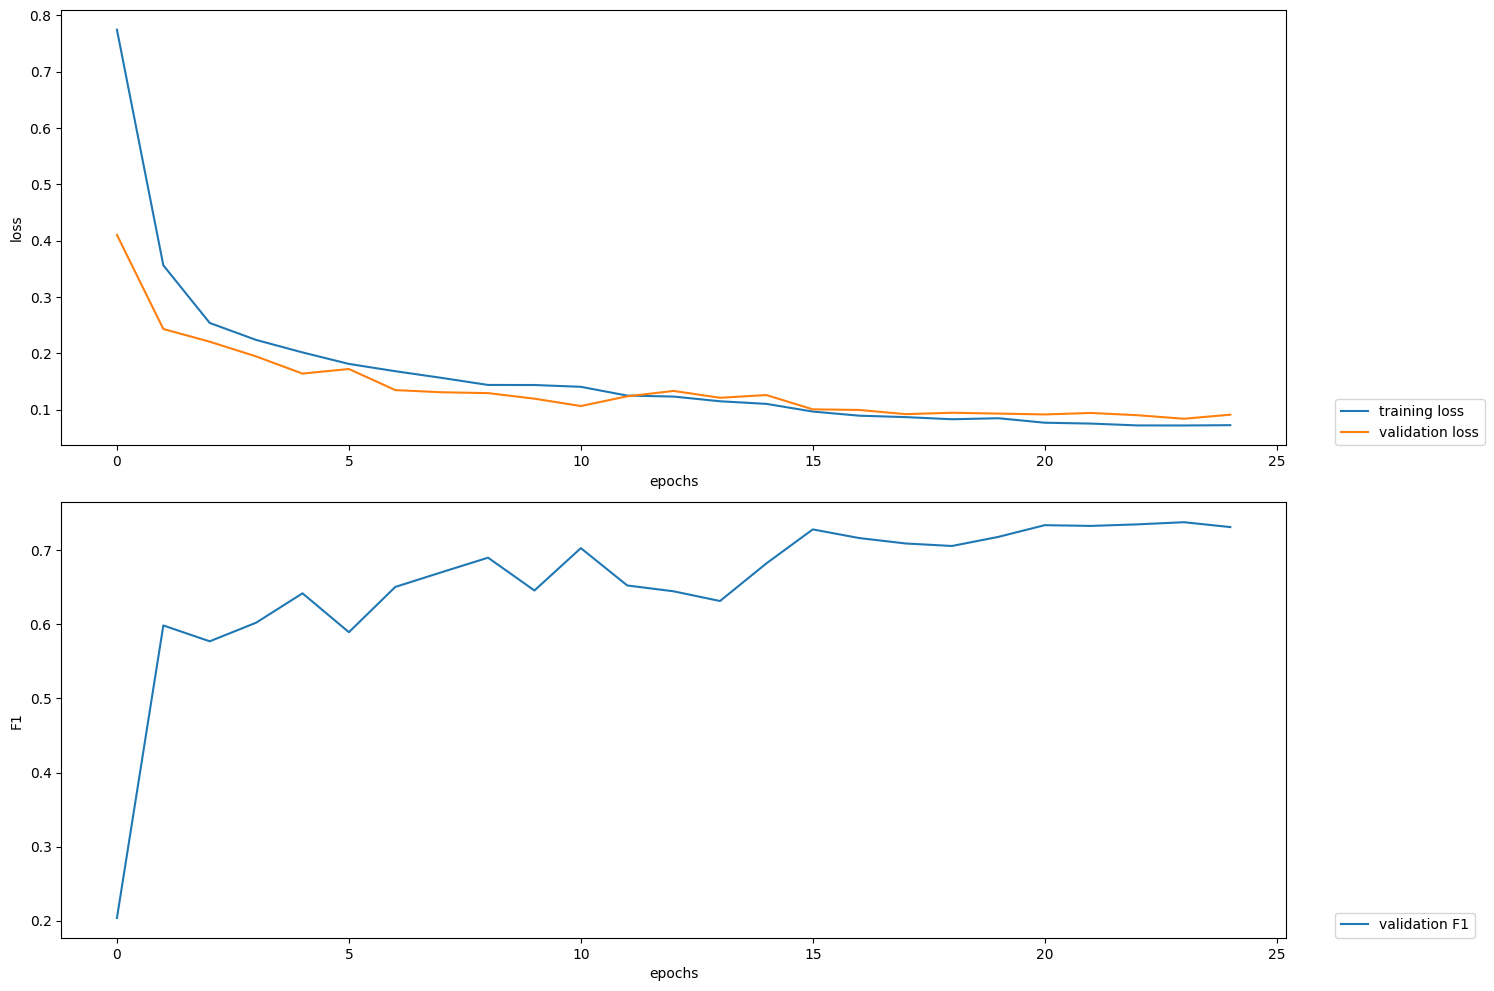

2023-09-18 16:29:56,658 Weights plots are saved in /content/drive/MyDrive/HAPLAPMaster/HAPLAPThesis/Seq-labeler/Flair-FR/Flair-ECHR-train-FR/Flair-Hug-model-FR-OT/weights.png


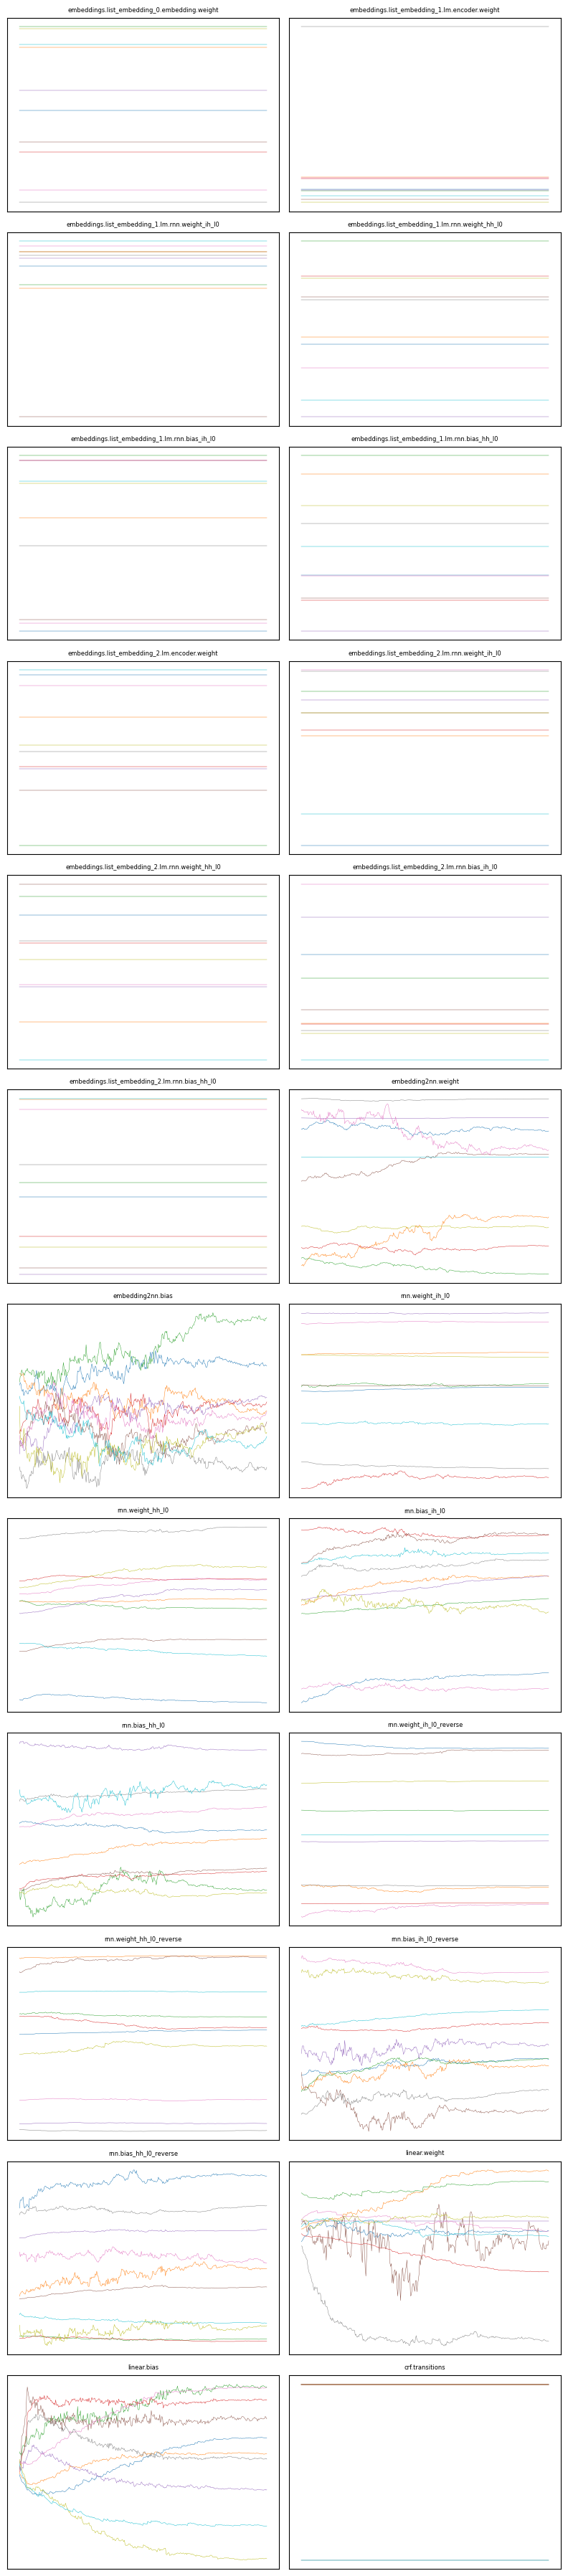

In [10]:
# plot training loss and weights
# Check documentation on training models with Flair

from flair.visual.training_curves import Plotter

plotter = Plotter()
plotter.plot_training_curves('/content/drive/MyDrive/.../loss.tsv')
plotter.plot_weights('/content/drive/MyDrive/.../weights.txt')